In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import shap
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import AdaBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor # RMSE 
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN

In [2]:
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)

# Data Dictionary

## KP Column 설명
- RECV_DEPT_NM : 접수부서 코드 ☆
- RECV_CPLT_DM : 접수완료 일시
- NPA_CL : 경찰청 구분 ☆
- EVT_STAT_CD : 사건 상태 코드
- EVT_CL_CD : 사건종별코드
- RPTER_SEX : 신고 성별 (남 : 1 / 여 : 2 / 불상 : 3)
- HPPN_PNU_ADDR : 발생지점(PNU)
- HPPN_X : 발생좌표X
- HPPN_Y : 발생좌표Y
- SME_EVT_YN : 동일사건여부 

## NPA Column 설명
- RECV_CPLT_DT : 접수완료일자
- RECV_CPLT_TM : 접수완료시간
- NPA_CL : 경찰청 구분 ☆
- EVT_STAT_CD : 사건 상태 코드
- EVT_CL_CD : 사건종별코드
- RPTER_SEX : 신고 성별 (남 : 1 / 여 : 2 / 불상 : 3)
- HPPN_PNU_ADDR : 발생지점(PNU)
- HPPN_X : 발생좌표X
- HPPN_Y : 발생좌표Y
- SME_EVT_YN : 동일사건여부 

In [3]:
KP2020 = pd.read_csv("./KP2020.csv", encoding = 'cp949')
KP2020

,RECV_DEPT_NM,RECV_CPLT_DM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_PNU_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,충남청,20/12/01 01:43:07.000000000,19,10,305,1.0,충청남도 보령시 궁촌동(행정:대천4동) 369,126.598345,36.341537,Y
1,대전청,20/12/01 02:05:04.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
2,대전청,20/12/01 02:06:52.000000000,13,10,601,1.0,NaN,127.404663,36.341685,NaN
3,충남청,20/12/01 02:37:25.000000000,19,10,606,3.0,충청남도 보령시 천북면 하만리 628-10,126.524980,36.474390,N
4,충남청,20/12/01 08:17:50.000000000,19,10,401,2.0,충청남도 천안시 서북구 성정동(행정:성정2동) 1259,127.137160,36.826718,NaN
...,...,...,...,...,...,...,...,...,...,...
77072,충남청,20/12/31 01:18:16.000000000,19,10,302,2.0,충청남도 보령시 주교면 주교리(행정:주교면) 191-6,126.571002,36.387791,NaN
77073,충남청,20/12/31 01:17:45.000000000,19,10,501,3.0,NaN,NaN,NaN,NaN
77074,충남청,20/12/31 00:13:50.000000000,19,10,604,3.0,충청남도 아산시 온천동(행정:온양1동) 1498,127.000391,36.788411,NaN
77075,대전청,20/12/31 00:49:29.000000000,13,10,302,2.0,대전광역시 서구 갈마동(행정:갈마2동) 975,127.373351,36.348051,Y


In [4]:
KP2021 = pd.read_csv("./KP2021.csv", encoding = 'cp949')
KP2021

,RECV_DEPT_NM,RECV_CPLT_DM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_PNU_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,대전청,21/03/07 00:00:01.000000000,13,10,604,3.0,대전광역시 서구 둔산동 1122,127.373676,36.350975,Y
1,대전청,21/03/07 00:02:13.000000000,13,10,201,1.0,대전광역시 유성구 상대동(원신흥동) 469-9,127.339018,36.347420,NaN
2,대전청,21/03/07 00:00:33.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
3,대전청,21/03/07 00:01:18.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
4,대전청,21/03/07 00:01:43.000000000,13,10,308,1.0,대전광역시 중구 선화동 141-16,127.420455,36.330413,NaN
...,...,...,...,...,...,...,...,...,...,...
2594055,대전청,23/01/12 11:23:09.000000000,13,10,104,1.0,대전광역시 유성구 봉명동 (행정:원신흥동 ) 1016-7,127.344600,36.352272,NaN
2594056,충남청,23/01/16 11:59:47.000000000,19,10,307,2.0,충청남도 서산시 음암면 부장리(음암면 ) 560-4,126.514047,36.785626,NaN
2594057,충남청,23/01/16 11:58:54.000000000,19,10,601,3.0,NaN,NaN,NaN,NaN
2594058,충남청,23/01/14 01:00:47.000000000,19,10,601,3.0,NaN,NaN,NaN,NaN


In [5]:
NPA2020 = pd.read_csv("./NPA2020.csv", encoding = 'cp949')
NPA2020

,RECV_CPLT_DT,RECV_CPLT_TM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_OLD_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,20200101,7,13,10,501,2,대전광역시 중구 목동(행정:목동) 360,127.409270,36.333010,Y
1,20200101,132,13,10,501,1,대전광역시 중구 대흥동(대흥동) 499-1,127.421295,36.325575,NaN
2,20200101,39,13,10,501,1,NaN,127.404663,36.341685,NaN
3,20200101,110,13,10,601,3,NaN,0.000000,0.000000,NaN
4,20200101,342,13,10,601,1,NaN,127.404663,36.341685,NaN
...,...,...,...,...,...,...,...,...,...,...
1178239,20201122,3505,19,10,501,1,,NaN,NaN,
1178240,20201122,5213,13,10,601,,,127.404663,36.341685,
1178241,20201122,4627,19,10,601,1,,NaN,NaN,Y
1178242,20201122,5246,19,5,301,1,충청남도 보령시 신흑동(행정:대천5동),126.516040,36.305619,


In [6]:
NPA2020['NPA_CL'].unique

<bound method Series.unique of 0          13
1          13
2          13
3          13
4          13
           ..
1178239    19
1178240    13
1178241    19
1178242    19
1178243    13
Name: NPA_CL, Length: 1178244, dtype: int64>

In [7]:
KP2020.isna().sum()

RECV_DEPT_NM         0
RECV_CPLT_DM         0
NPA_CL               0
EVT_STAT_CD          0
EVT_CL_CD            0
RPTER_SEX         2419
HPPN_PNU_ADDR    29272
HPPN_X           16764
HPPN_Y           16764
SME_EVT_YN       63635
dtype: int64

In [8]:
KP2021.isna().sum()

RECV_DEPT_NM           0
RECV_CPLT_DM           0
NPA_CL                 0
EVT_STAT_CD            0
EVT_CL_CD              0
RPTER_SEX          23894
HPPN_PNU_ADDR    1072094
HPPN_X            694401
HPPN_Y            694401
SME_EVT_YN       2079123
dtype: int64

In [9]:
NPA2020.isna().sum()

RECV_CPLT_DT          0
RECV_CPLT_TM          0
NPA_CL                0
EVT_STAT_CD           0
EVT_CL_CD             0
RPTER_SEX             0
HPPN_OLD_ADDR    258593
HPPN_X           101653
HPPN_Y           101653
SME_EVT_YN       596801
dtype: int64

- RECV_DEPT_NM : 버려도 될 듯
- RPTER_SEX : INT(FLOAT)로 통일
- HPPN_PNU_ADDR : 버려도 될 듯
- SEX : NAN값 -> 3으로 바꾸기

- HPPN_X, HPPN_Y : 위도 경도 결측치 →  버리기
- SME_EVT_YN : 결측치 N으로 바꾸기 - 1명

- RECV_CPLT_DT, RECV_CPLT_TM : 년도 / 월 / 일 / 시 / 분 / 초 단위로 나누기 - 1명 
- RECV_CPLT_DM : 년도 / 월 / 일 / 시 / 분 / 초 단위로 나누기
- 신무진

- EVT_CL_CD : 종별 코드 → 보이스피싱 / 교통사고 분류 : 4인거만 찾아내기 - 1명 해버림

![nn](./KakaoTalk_20230204_155422740.png)

In [10]:
x = NPA2020[NPA2020['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
NPA2020 = y

x = KP2021[KP2021['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
KP2021 = y

x = KP2020[KP2020['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
KP2020 = y

#KP2020.drop('RECV_DEPT_NM', axis = 1, inplace = True)
#KP2021.drop('RECV_DEPT_NM', axis = 1, inplace = True)

KP2020.drop('HPPN_PNU_ADDR', axis = 1, inplace = True)
KP2021.drop('HPPN_PNU_ADDR', axis = 1, inplace = True)
NPA2020.drop('HPPN_OLD_ADDR', axis = 1, inplace = True)
#드롭

NPA2020 = NPA2020.drop([42819, 250145, 551827, 609589, 659384, 767378, 802443, 838056, 1044961])

NPA2020["RPTER_SEX"] = NPA2020["RPTER_SEX"].fillna(3).astype(int)
KP2020["RPTER_SEX"] = KP2020["RPTER_SEX"].fillna(3).astype(int)
KP2021["RPTER_SEX"] = KP2021["RPTER_SEX"].fillna(3).astype(int)

#SEX : NAN값 -> 3으로 바꾸기

In [11]:
KP2020['RECV_CPLT_DM'] = KP2020['RECV_CPLT_DM'].astype(str)

def add_20(a):
    return '20'+ a

KP2020['TIME'] = KP2020['RECV_CPLT_DM'].apply(add_20)

# 년
KP2020['YEAR'] =  pd.to_datetime(KP2020['TIME']).dt.year

# 월
KP2020['MONTH'] =  pd.to_datetime(KP2020['TIME']).dt.month

# 일
KP2020['DAY'] =  pd.to_datetime(KP2020['TIME']).dt.day

# 시
KP2020['HOUR'] =  pd.to_datetime(KP2020['TIME']).dt.hour

# 분
KP2020['MINUTE'] =  pd.to_datetime(KP2020['TIME']).dt.minute

# 초
KP2020['SECOND'] =  pd.to_datetime(KP2020['TIME']).dt.second

#요일
KP2020['DAY_OF_WEEK'] = pd.to_datetime(KP2020['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
KP2020 = KP2020.drop(['RECV_CPLT_DM','TIME'], axis = 1)

KP2021['RECV_CPLT_DM'] = KP2021['RECV_CPLT_DM'].astype(str)

KP2021['TIME'] = KP2021['RECV_CPLT_DM'].apply(add_20)

# 년
KP2021['YEAR'] =  pd.to_datetime(KP2021['TIME']).dt.year

# 월
KP2021['MONTH'] =  pd.to_datetime(KP2021['TIME']).dt.month

# 일
KP2021['DAY'] =  pd.to_datetime(KP2021['TIME']).dt.day

# 시
KP2021['HOUR'] =  pd.to_datetime(KP2021['TIME']).dt.hour

# 분
KP2021['MINUTE'] =  pd.to_datetime(KP2021['TIME']).dt.minute

# 초
KP2021['SECOND'] =  pd.to_datetime(KP2021['TIME']).dt.second

# 요일
KP2021['DAY_OF_WEEK'] = pd.to_datetime(KP2021['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
KP2021= KP2021.drop(['RECV_CPLT_DM','TIME'], axis = 1)

NPA2020['RECV_CPLT_DT'] = NPA2020['RECV_CPLT_DT'].astype(str)
NPA2020['RECV_CPLT_DT'].info()

def silce_year(a):
    return a[:4]
def silce_month(a):
    return a[4:6]
def silce_day(a):
    return a[6:]

# 년
NPA2020['YEAR'] = NPA2020['RECV_CPLT_DT'].apply(silce_year)
NPA2020['YEAR']
# 월
NPA2020['MONTH'] = NPA2020['RECV_CPLT_DT'].apply(silce_month)
NPA2020['MONTH']
# 일
NPA2020['DAY'] = NPA2020['RECV_CPLT_DT'].apply(silce_day)
NPA2020['DAY']

NPA2020['RECV_CPLT_TM'] = NPA2020['RECV_CPLT_TM'].astype(str)

def add_00(a):
    if len(a) == 6:
        return a
    elif len(a) == 5:
        return '0' + a
    elif len(a) == 4:
        return '0' * 2 + a
    elif len(a) == 3:
        return '0' * 3 + a
    elif len(a) == 2:
        return '0' * 4 + a
    else:
        return '0' * 5 + a

NPA2020['TIME'] = NPA2020['RECV_CPLT_TM'].apply(add_00)

def silce_hour(a):
    return a[:2]

def silce_min(a):
    return a[2:4]

def silce_sec(a):
    return a[4:]

# 시
NPA2020['HOUR'] = NPA2020['TIME'].apply(silce_hour)
NPA2020['HOUR']

# 분
NPA2020['MINUTE'] = NPA2020['TIME'].apply(silce_min)
NPA2020['MINUTE']

# 초
NPA2020['SECOND'] = NPA2020['TIME'].apply(silce_sec)
NPA2020['SECOND']

# 요일
NPA2020['TIME'] = NPA2020['YEAR'] + NPA2020['MONTH'] + NPA2020['DAY']
NPA2020['DAY_OF_WEEK'] = pd.to_datetime(NPA2020['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
NPA2020 = NPA2020.drop(['TIME', 'RECV_CPLT_TM', 'RECV_CPLT_DT'], axis = 1)

<class 'pandas.core.series.Series'>
Int64Index: 142919 entries, 38 to 1178234
Series name: RECV_CPLT_DT
Non-Null Count   Dtype 
--------------   ----- 
142919 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


In [12]:
# 위도, 경도 결측치 행 제거
KP2020 = KP2020.dropna(subset = ['HPPN_X','HPPN_Y'])
KP2021 = KP2021.dropna(subset = ['HPPN_X','HPPN_Y'])
NPA2020 = NPA2020.dropna(subset = ['HPPN_X','HPPN_Y'])

# 결측치 N으로 바꾸기
KP2020['SME_EVT_YN'] = KP2020['SME_EVT_YN'].fillna('N')
KP2021['SME_EVT_YN'] = KP2021['SME_EVT_YN'].fillna('N')
NPA2020['SME_EVT_YN'] = NPA2020['SME_EVT_YN'].fillna('N')

def N_rep(x):
    if x == ' ':
        return 'N'
    else:
        return x

NPA2020['SME_EVT_YN'] = NPA2020['SME_EVT_YN'].apply(N_rep)
NPA2020['SME_EVT_YN']

38         N
41         N
54         N
66         N
117        N
          ..
1178083    N
1178086    Y
1178143    N
1178173    Y
1178234    N
Name: SME_EVT_YN, Length: 140958, dtype: object

In [13]:
NPA2020

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
38,13,10,402,1,127.386346,36.346856,N,2020,01,01,00,32,40,Wednesday
41,13,10,406,1,127.349989,36.360797,N,2020,01,01,00,35,32,Wednesday
54,13,10,401,1,127.348625,36.353829,N,2020,01,01,00,21,35,Wednesday
66,13,10,401,1,127.405055,36.328573,N,2020,01,01,00,43,01,Wednesday
117,13,10,401,3,127.445780,36.345500,N,2020,01,01,18,43,35,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178083,13,7,406,1,127.404540,36.325219,N,2020,11,22,00,20,07,Sunday
1178086,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,40,08,Sunday
1178143,19,5,406,3,127.107617,36.813773,N,2020,11,22,00,57,19,Sunday
1178173,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,37,53,Sunday


In [14]:
KP2021

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
14,충남청,19,10,406,1,127.107500,36.811944,N,2021,3,7,0,2,48,Sunday
20,충남청,19,10,402,1,127.150988,36.811792,Y,2021,3,7,0,9,4,Sunday
23,대전청,13,10,401,2,127.371854,36.341961,N,2021,3,7,0,7,54,Sunday
26,대전청,13,10,401,1,127.339334,36.346899,N,2021,3,7,0,15,27,Sunday
44,충남청,19,10,403,2,127.090733,36.453397,N,2021,3,7,0,12,8,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593994,대전청,13,10,401,1,127.384284,36.334507,N,2023,1,15,20,1,39,Sunday
2594002,충남청,19,10,401,1,126.262393,36.751467,N,2023,1,16,21,26,56,Monday
2594006,충남청,19,10,403,2,127.147678,36.789125,N,2023,1,14,1,2,48,Saturday
2594019,대전청,13,10,401,1,127.433785,36.450725,N,2023,1,14,17,35,38,Saturday


In [15]:
KP2020

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77024,충남청,19,10,406,1,126.298968,36.747649,Y,2020,12,31,0,16,14,Thursday
77036,대전청,13,10,401,1,127.428343,36.324386,N,2020,12,31,1,8,43,Thursday
77066,충남청,19,10,406,1,126.298968,36.747649,Y,2020,12,31,0,26,16,Thursday
77068,대전청,13,10,401,1,127.369099,36.312971,N,2020,12,31,1,17,1,Thursday


In [16]:
NPA2020['NPA_CL'].unique()

array([13, 19], dtype=int64)

In [17]:
c = pd.concat([KP2020, KP2021])
c

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593994,대전청,13,10,401,1,127.384284,36.334507,N,2023,1,15,20,1,39,Sunday
2594002,충남청,19,10,401,1,126.262393,36.751467,N,2023,1,16,21,26,56,Monday
2594006,충남청,19,10,403,2,127.147678,36.789125,N,2023,1,14,1,2,48,Saturday
2594019,대전청,13,10,401,1,127.433785,36.450725,N,2023,1,14,17,35,38,Saturday


In [18]:
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '대전파출소', '대전중부', '대전유성', '서대전지구대', '남대전지구대',
       '대전역지구대', '세종', '대전동부', '세종청', '대전둔산', '대전대덕', '세종로파출소', '대전서부',
       '세종서', '대전동부서', '대전서부서', '대전중부서', '대전둔산서', '대전유성서', '대전대덕서',
       '세종남부서', '세종북부서', '세종대왕파출소'], dtype=object)

In [19]:
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '대전파출소', '대전중부', '대전유성', '서대전지구대', '남대전지구대',
       '대전역지구대', '세종', '대전동부', '세종청', '대전둔산', '대전대덕', '세종로파출소', '대전서부',
       '세종서', '대전동부서', '대전서부서', '대전중부서', '대전둔산서', '대전유성서', '대전대덕서',
       '세종남부서', '세종북부서', '세종대왕파출소'], dtype=object)

In [20]:
c['NPA_CL'].unique()

array([19, 13, 31, 21, 11, 18, 15, 20, 10, 16,  8, 17, 22, 23, 12, 14,  9,
       24], dtype=int64)

In [21]:
c[c['RECV_DEPT_NM'] == '충남청']['NPA_CL'].unique()

array([19, 31, 11, 15, 18, 13, 20,  8, 22, 16, 23, 12, 21, 14,  9, 17, 10,
       24], dtype=int64)

In [22]:
for idx in c.index :
    if '대전' in c.loc[idx, 'RECV_DEPT_NM'] :
        c.loc[idx, 'RECV_DEPT_NM'] = '대전청'
    elif '충남' in c.loc[idx, 'RECV_DEPT_NM'] :
        c.loc[idx, 'RECV_DEPT_NM'] = '충남청'
    elif '세종' in c.loc[idx, 'RECV_DEPT_NM'] :
        c.loc[idx, 'RECV_DEPT_NM'] = '세종청'
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '대전파출소', '세종청', '대전유성', '서대전지구대', '남대전지구대', '대전대덕'],
      dtype=object)

In [23]:
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '대전파출소', '세종청', '대전유성', '서대전지구대', '남대전지구대', '대전대덕'],
      dtype=object)

In [24]:
c.loc[(c.RECV_DEPT_NM == '서대전지구대'), 'RECV_DEPT_NM'] = '대전청'
c.loc[(c.RECV_DEPT_NM == '남대전지구대'), 'RECV_DEPT_NM'] = '대전청'
c.loc[(c.RECV_DEPT_NM == '대전대덕'), 'RECV_DEPT_NM'] = '대전청'
c.loc[(c.RECV_DEPT_NM == '대전유성'), 'RECV_DEPT_NM'] = '대전청'
c.loc[(c.RECV_DEPT_NM == '대전파출소'), 'RECV_DEPT_NM'] = '대전청'

In [25]:
c['RECV_DEPT_NM'].unique()

array(['충남청', '대전청', '세종청'], dtype=object)

In [26]:
NPA2020.loc[(NPA2020.NPA_CL == 13), 'RECV_DEPT_NM'] = '대전청'
NPA2020.loc[(NPA2020.NPA_CL == 19), 'RECV_DEPT_NM'] = '충남청'
NPA2020

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK,RECV_DEPT_NM
38,13,10,402,1,127.386346,36.346856,N,2020,01,01,00,32,40,Wednesday,대전청
41,13,10,406,1,127.349989,36.360797,N,2020,01,01,00,35,32,Wednesday,대전청
54,13,10,401,1,127.348625,36.353829,N,2020,01,01,00,21,35,Wednesday,대전청
66,13,10,401,1,127.405055,36.328573,N,2020,01,01,00,43,01,Wednesday,대전청
117,13,10,401,3,127.445780,36.345500,N,2020,01,01,18,43,35,Wednesday,대전청
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178083,13,7,406,1,127.404540,36.325219,N,2020,11,22,00,20,07,Sunday,대전청
1178086,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,40,08,Sunday,대전청
1178143,19,5,406,3,127.107617,36.813773,N,2020,11,22,00,57,19,Sunday,충남청
1178173,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,37,53,Sunday,대전청


In [27]:
data = pd.concat([c, NPA2020])
data

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178083,대전청,13,7,406,1,127.404540,36.325219,N,2020,11,22,00,20,07,Sunday
1178086,대전청,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,40,08,Sunday
1178143,충남청,19,5,406,3,127.107617,36.813773,N,2020,11,22,00,57,19,Sunday
1178173,대전청,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,37,53,Sunday


In [28]:
data.describe()

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y
count,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000
mean,17.241625,9.987984,402.125468,1.390434,126.088176,36.242524
std,3.983437,0.235342,1.817076,0.662202,11.461662,3.302529
min,8.000000,2.000000,401.000000,1.000000,0.000000,0.000000
25%,13.000000,10.000000,401.000000,1.000000,127.008599,36.341685
50%,19.000000,10.000000,401.000000,1.000000,127.167879,36.458332
75%,19.000000,10.000000,402.000000,2.000000,127.379848,36.787168
max,31.000000,10.000000,406.000000,3.000000,129.435259,38.211177


In [29]:
data.describe(include=['O']) #범주형 데이터 확인

,RECV_DEPT_NM,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
count,426761,426761,426761,426761,426761,426761,426761,426761,426761
unique,3,2,5,23,62,48,120,120,7
top,충남청,N,2020,12,14,18,16,50,Saturday
freq,266409,346144,140958,32226,9728,20131,4938,4943,68027


In [30]:
data['YEAR'] = data['YEAR'].astype(int)
data['MONTH'] = data['MONTH'].astype(int)
data['DAY'] = data['DAY'].astype(int)
data['HOUR'] = data['HOUR'].astype(int)
data['MINUTE'] = data['MINUTE'].astype(int)
data['SECOND'] = data['SECOND'].astype(int)

In [31]:
data.describe()

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
count,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000
mean,17.241625,9.987984,402.125468,1.390434,126.088176,36.242524,2021.006884,6.655015,15.650488,13.650069,29.410286,29.445551
std,3.983437,0.235342,1.817076,0.662202,11.461662,3.302529,0.859965,3.364927,8.767696,6.236315,17.297096,17.307435
min,8.000000,2.000000,401.000000,1.000000,0.000000,0.000000,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,13.000000,10.000000,401.000000,1.000000,127.008599,36.341685,2020.000000,4.000000,8.000000,10.000000,14.000000,15.000000
50%,19.000000,10.000000,401.000000,1.000000,127.167879,36.458332,2021.000000,7.000000,16.000000,15.000000,29.000000,29.000000
75%,19.000000,10.000000,402.000000,2.000000,127.379848,36.787168,2022.000000,10.000000,23.000000,19.000000,44.000000,44.000000
max,31.000000,10.000000,406.000000,3.000000,129.435259,38.211177,2023.000000,12.000000,31.000000,23.000000,59.000000,59.000000


In [32]:
acc401 = data[data['EVT_CL_CD'] == 401] # 교통사고
acc402 = data[data['EVT_CL_CD'] == 402] # 교통불편
acc403 = data[data['EVT_CL_CD'] == 403] # 교통위반
acc404 = data[data['EVT_CL_CD'] == 404] # 사망, 대형사고
acc405 = data[data['EVT_CL_CD'] == 405] # 인피도주 (뺑소니)
acc406 = data[data['EVT_CL_CD'] == 406] # 음주운전

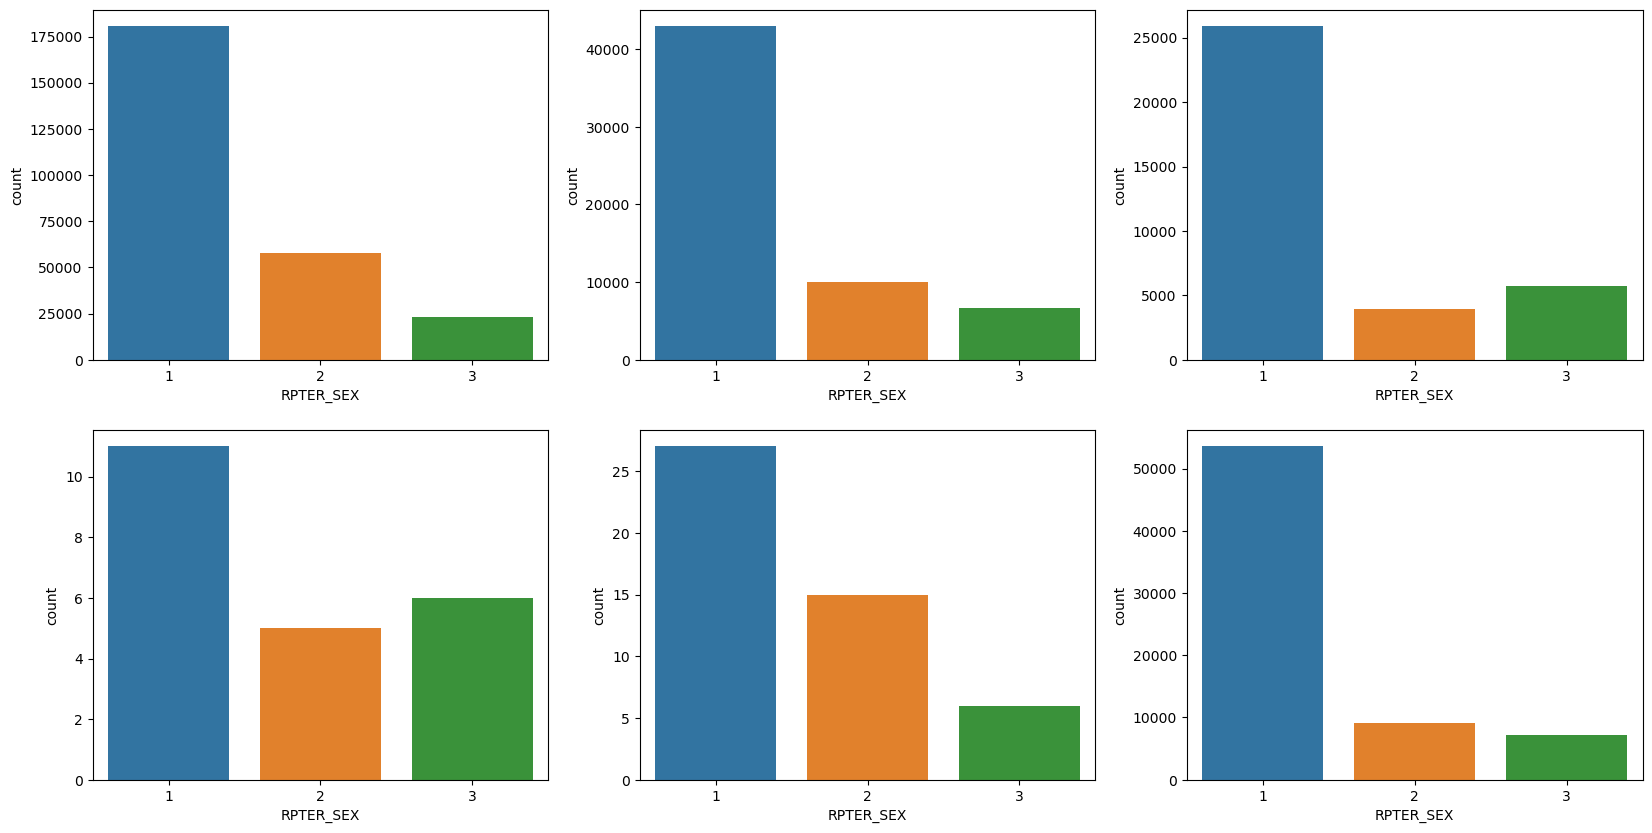

In [33]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(20,10)

ax = sns.countplot(x="RPTER_SEX", data=acc401, ax = axes[0])
ax = sns.countplot(x="RPTER_SEX", data=acc402, ax = axes[1])
ax = sns.countplot(x="RPTER_SEX", data=acc403, ax = axes[2])
ax = sns.countplot(x="RPTER_SEX", data=acc404, ax = axes[3])
ax = sns.countplot(x="RPTER_SEX", data=acc405, ax = axes[4])
ax = sns.countplot(x="RPTER_SEX", data=acc406, ax = axes[5])

plt.show()

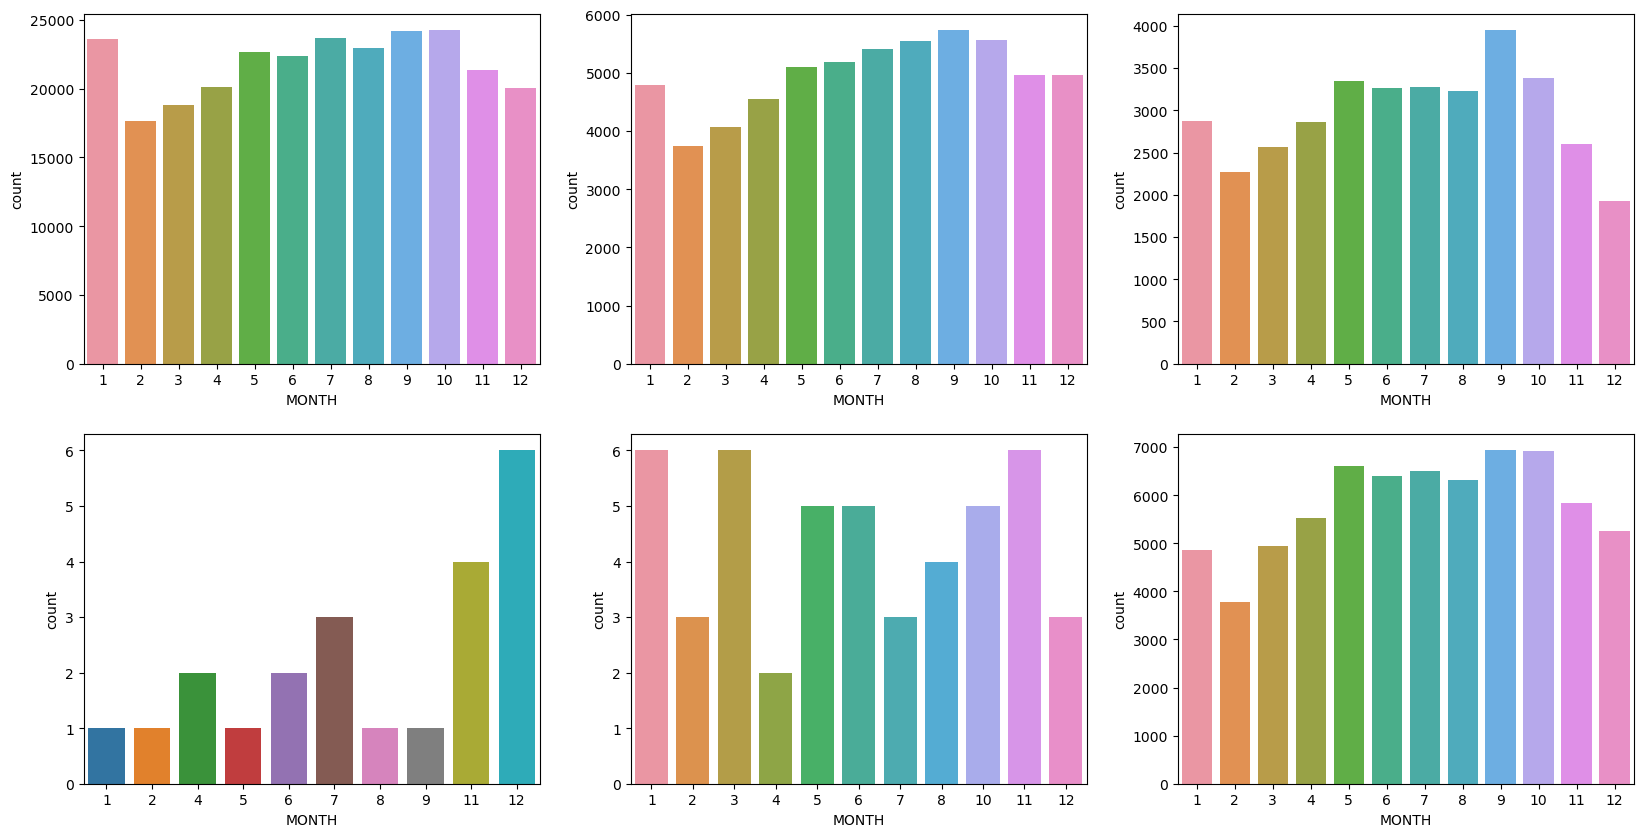

In [34]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(20,10)

ax = sns.countplot(x="MONTH", data=acc401, ax = axes[0])
ax = sns.countplot(x="MONTH", data=acc402, ax = axes[1])
ax = sns.countplot(x="MONTH", data=acc403, ax = axes[2])
ax = sns.countplot(x="MONTH", data=acc404, ax = axes[3])
ax = sns.countplot(x="MONTH", data=acc405, ax = axes[4])
ax = sns.countplot(x="MONTH", data=acc406, ax = axes[5])

plt.show()

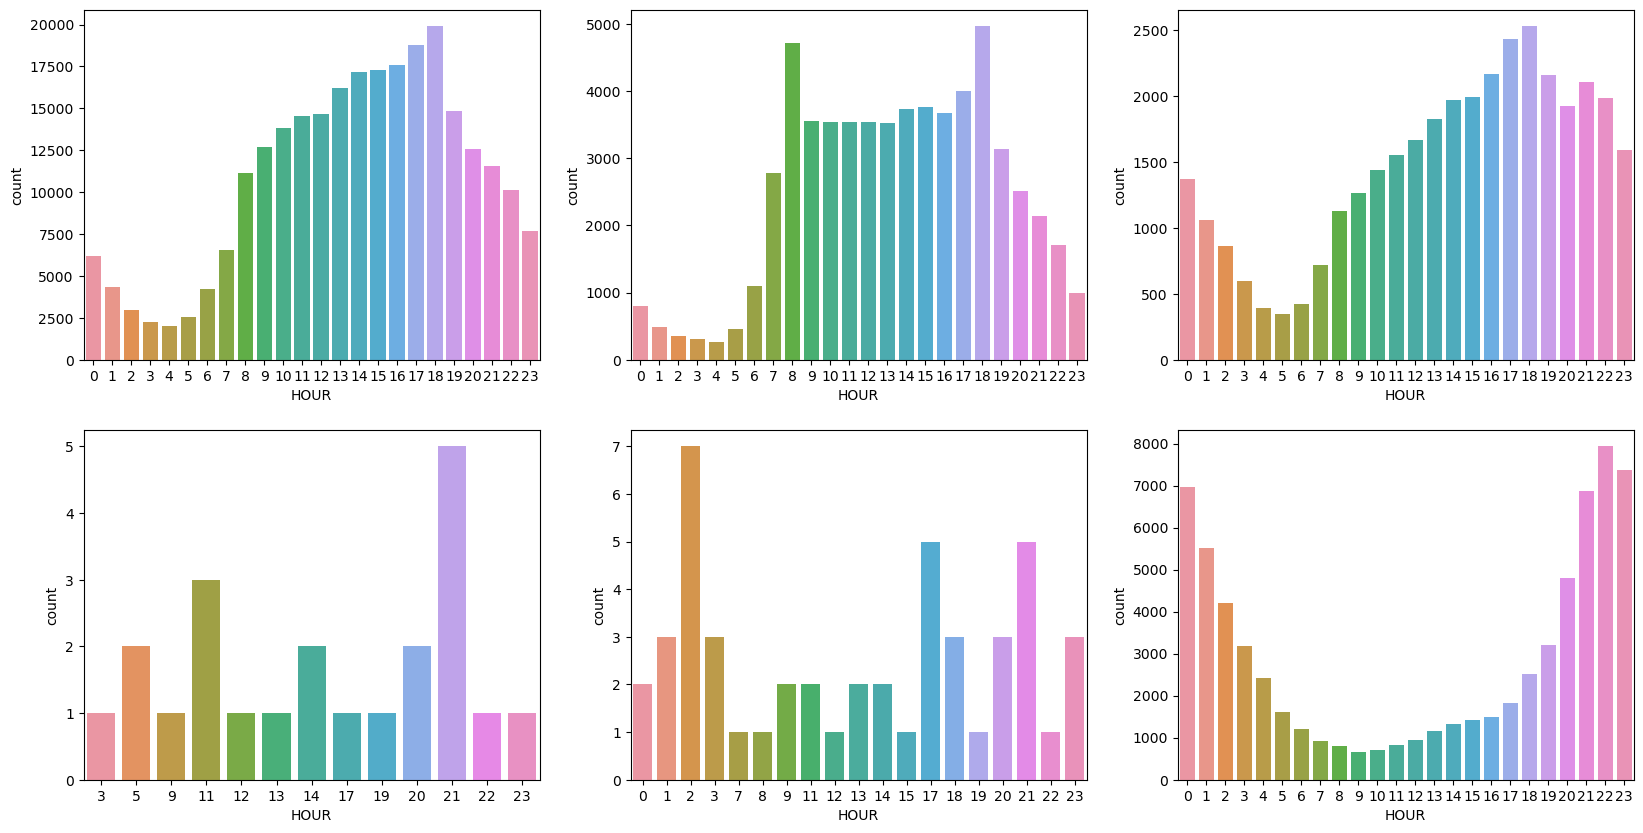

In [35]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(20,10)

ax = sns.countplot(x="HOUR", data=acc401, ax = axes[0])
ax = sns.countplot(x="HOUR", data=acc402, ax = axes[1])
ax = sns.countplot(x="HOUR", data=acc403, ax = axes[2])
ax = sns.countplot(x="HOUR", data=acc404, ax = axes[3])
ax = sns.countplot(x="HOUR", data=acc405, ax = axes[4])
ax = sns.countplot(x="HOUR", data=acc406, ax = axes[5])

plt.show()

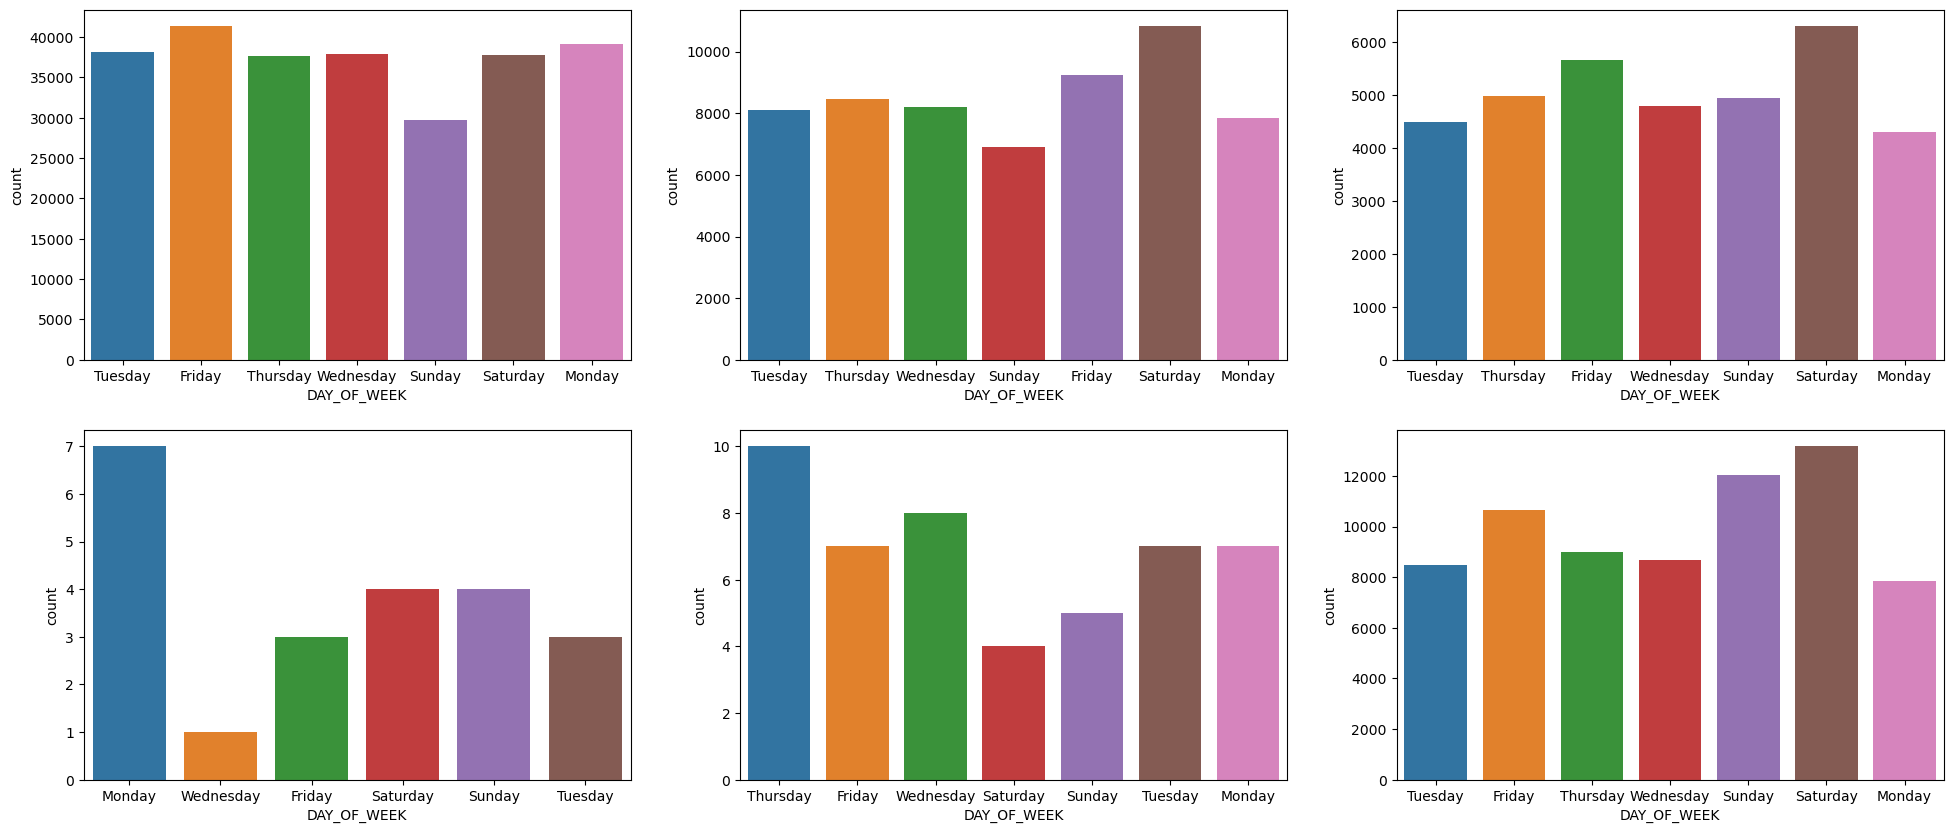

In [36]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(24,10)

ax = sns.countplot(x="DAY_OF_WEEK", data=acc401, ax = axes[0])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc402, ax = axes[1])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc403, ax = axes[2])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc404, ax = axes[3])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc405, ax = axes[4])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc406, ax = axes[5])

plt.show()

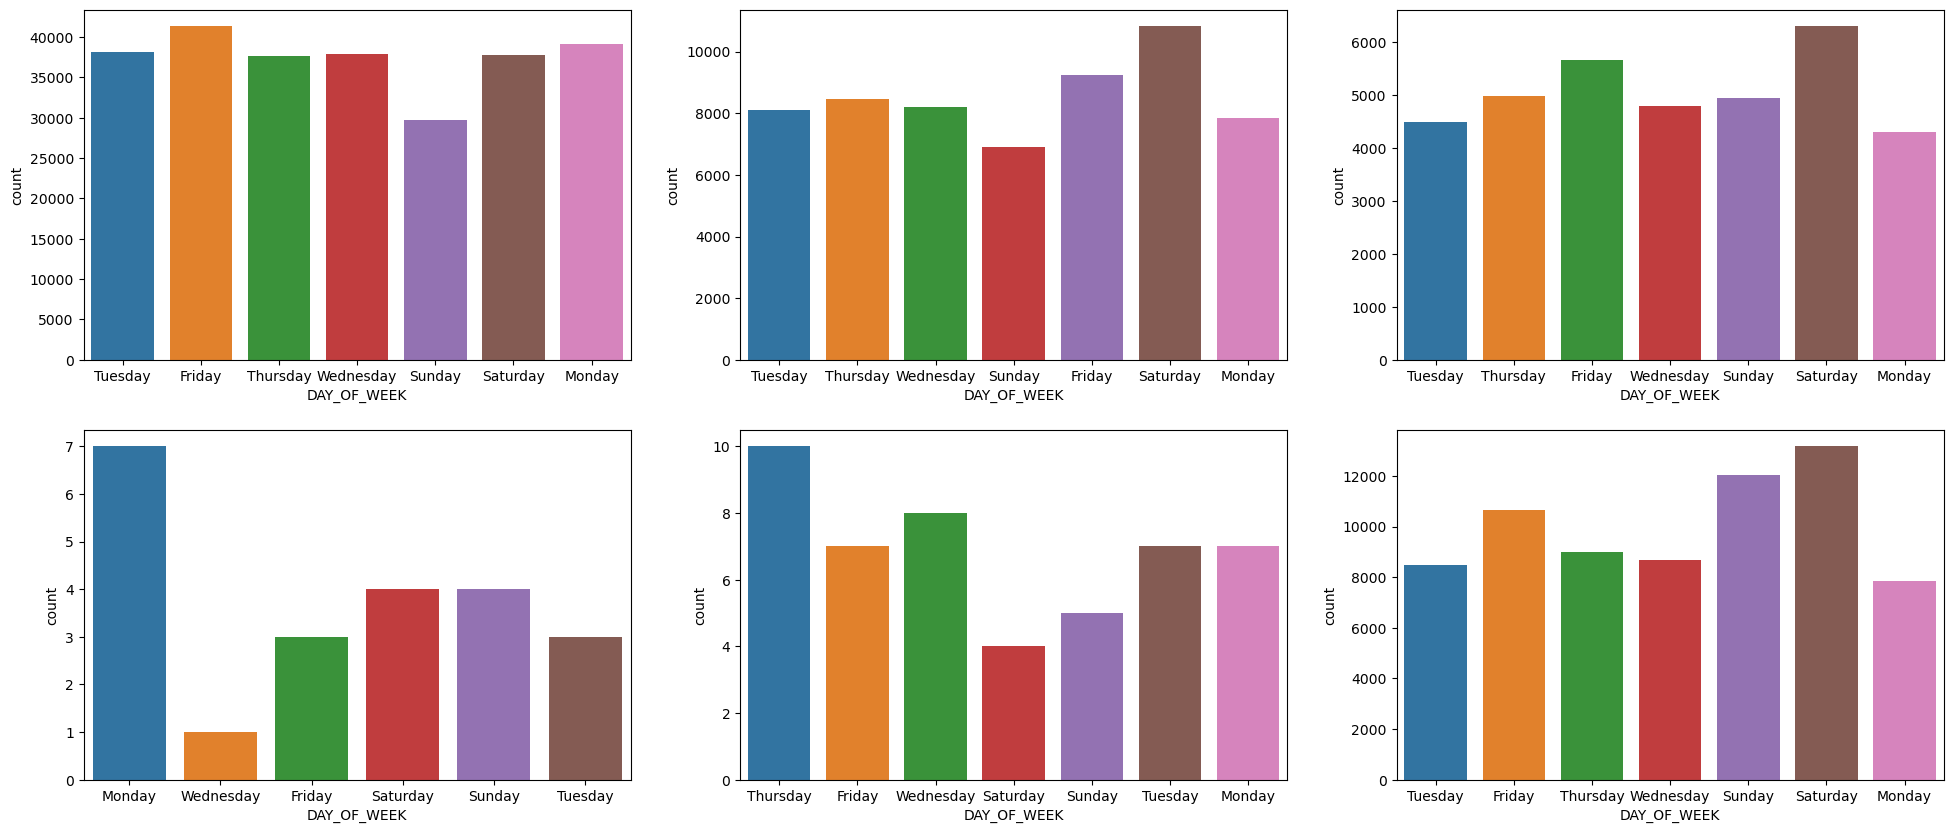

In [37]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(24,10)

ax = sns.countplot(x="DAY_OF_WEEK", data=acc401, ax = axes[0])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc402, ax = axes[1])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc403, ax = axes[2])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc404, ax = axes[3])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc405, ax = axes[4])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc406, ax = axes[5])

plt.show()

In [34]:
data['EVT_STAT_CD'].value_counts()

10    425597
5        791
7        353
3          8
6          6
2          4
9          2
Name: EVT_STAT_CD, dtype: int64

In [35]:
data.loc[data.EVT_STAT_CD == 7,'EVT_STAT_CD'] = 10

In [36]:
data.drop(data.loc[data.EVT_STAT_CD == 9].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 3].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 2].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 6].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 5].index, inplace = True)

In [37]:
data['NPA_CL'].value_counts()

19    247466
13    156251
31     16658
18      2352
15      1977
20       679
21       142
8        116
11        73
16        35
22        34
10        19
17        18
23        17
9         14
12        12
24         9
14         7
Name: NPA_CL, dtype: int64

In [38]:
data.drop(data.loc[data.NPA_CL == 14].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 24].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 12].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 9].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 23].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 17].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 10].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 22].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 16].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 11].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 8].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 21].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 20].index, inplace = True)
data.drop(data.loc[data.NPA_CL == 15].index, inplace = True)

In [39]:
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 24),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 26),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 1)&(data.DAY == 27),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 4)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 4)&(data.DAY == 30),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 8)&(data.DAY == 17),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 9)&(data.DAY == 30),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 2),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2020)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'

In [40]:
data.loc[(data.YEAR == 2021)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 11),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 12),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 2)&(data.DAY == 13),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 5)&(data.DAY == 19),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 20),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 21),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 9)&(data.DAY == 22),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2021)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'

In [41]:
data.loc[(data.YEAR == 2022)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 1)&(data.DAY == 31),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 2),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 2)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 3)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 5)&(data.DAY == 5),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 5)&(data.DAY == 8),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 6)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 6)&(data.DAY == 6),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 8)&(data.DAY == 15),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 10),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 11),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 9)&(data.DAY == 12),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 3),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 9),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 10)&(data.DAY == 10),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2022)&(data.MONTH == 12)&(data.DAY == 25),'DAY_OF_WEEK'] = 'Holiday'

In [42]:
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 21),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 22),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 23),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 1)&(data.DAY == 24),'DAY_OF_WEEK'] = 'Holiday'
data.loc[(data.YEAR == 2023)&(data.MONTH == 3)&(data.DAY == 1),'DAY_OF_WEEK'] = 'Holiday'

In [43]:
data['DAY_OF_WEEK'].unique()

array(['Tuesday', 'Friday', 'Thursday', 'Wednesday', 'Sunday', 'Saturday',
       'Monday', 'Holiday'], dtype=object)

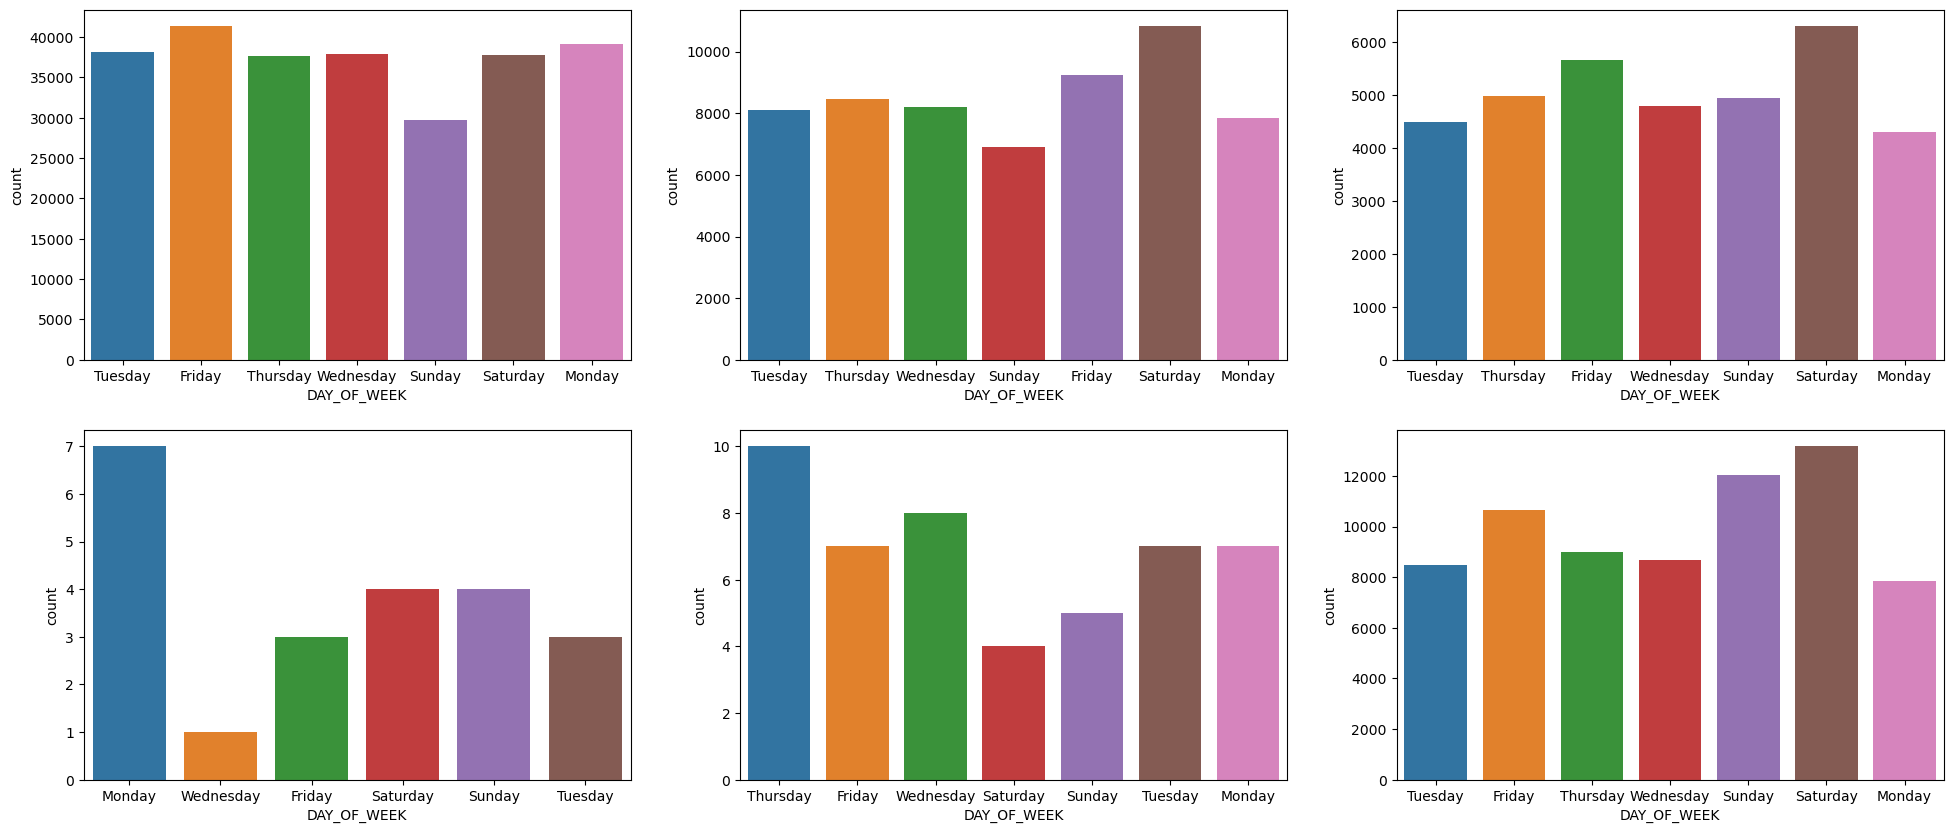

In [48]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(24,10)

ax = sns.countplot(x="DAY_OF_WEEK", data=acc401, ax = axes[0])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc402, ax = axes[1])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc403, ax = axes[2])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc404, ax = axes[3])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc405, ax = axes[4])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc406, ax = axes[5])

plt.show()

In [49]:
data.drop(data.loc[data.HPPN_X < 100].index, inplace = True)
data.drop(data.loc[data.HPPN_Y < 30].index, inplace = True)

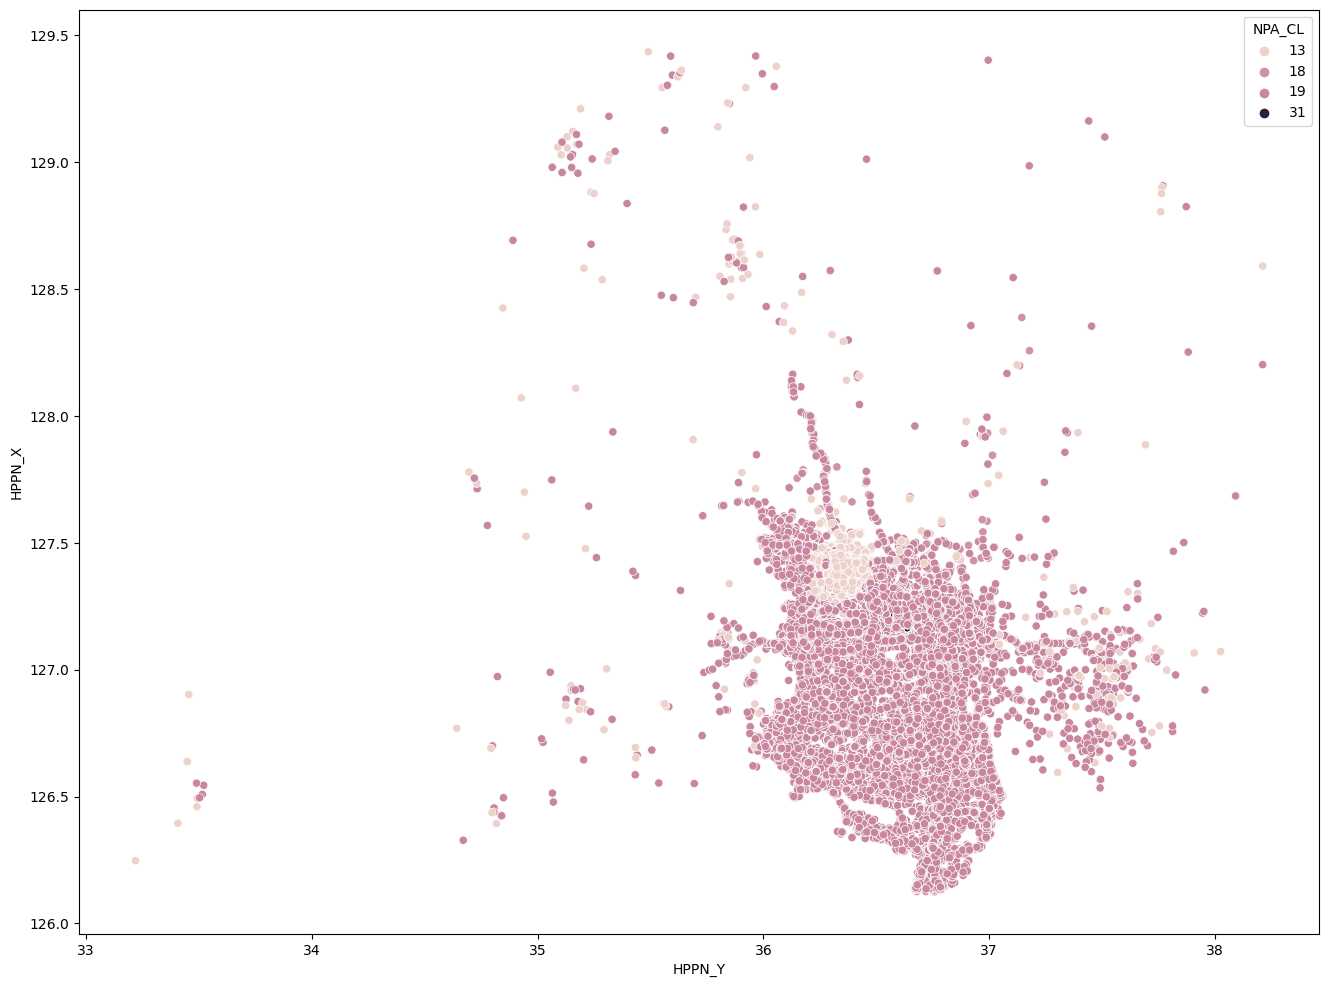

In [51]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="HPPN_Y", y="HPPN_X", hue="NPA_CL")
plt.show()

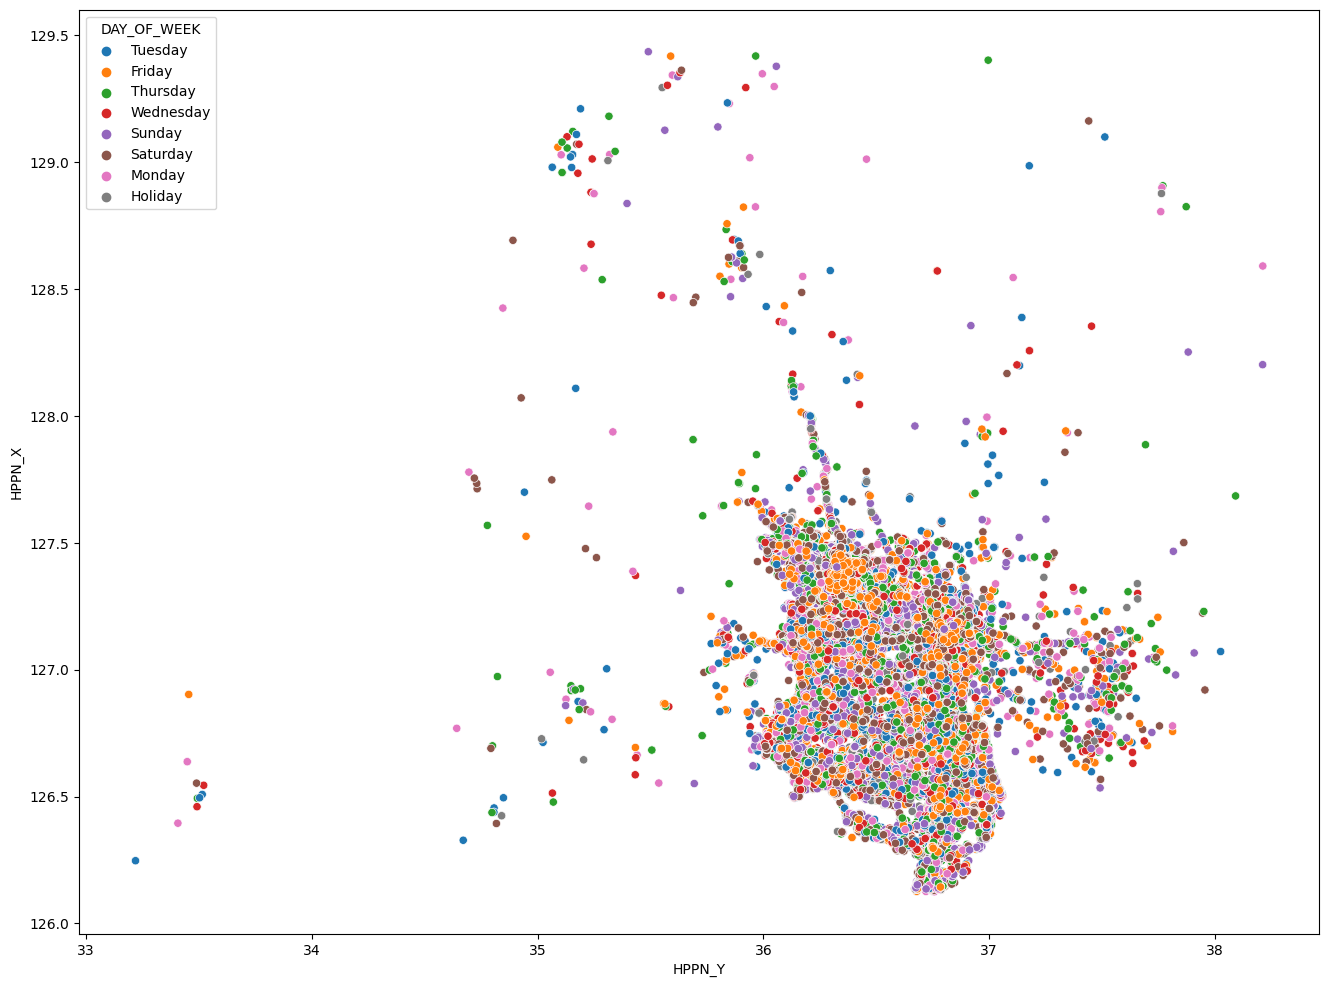

In [52]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="HPPN_Y", y="HPPN_X", hue="DAY_OF_WEEK")
plt.show()

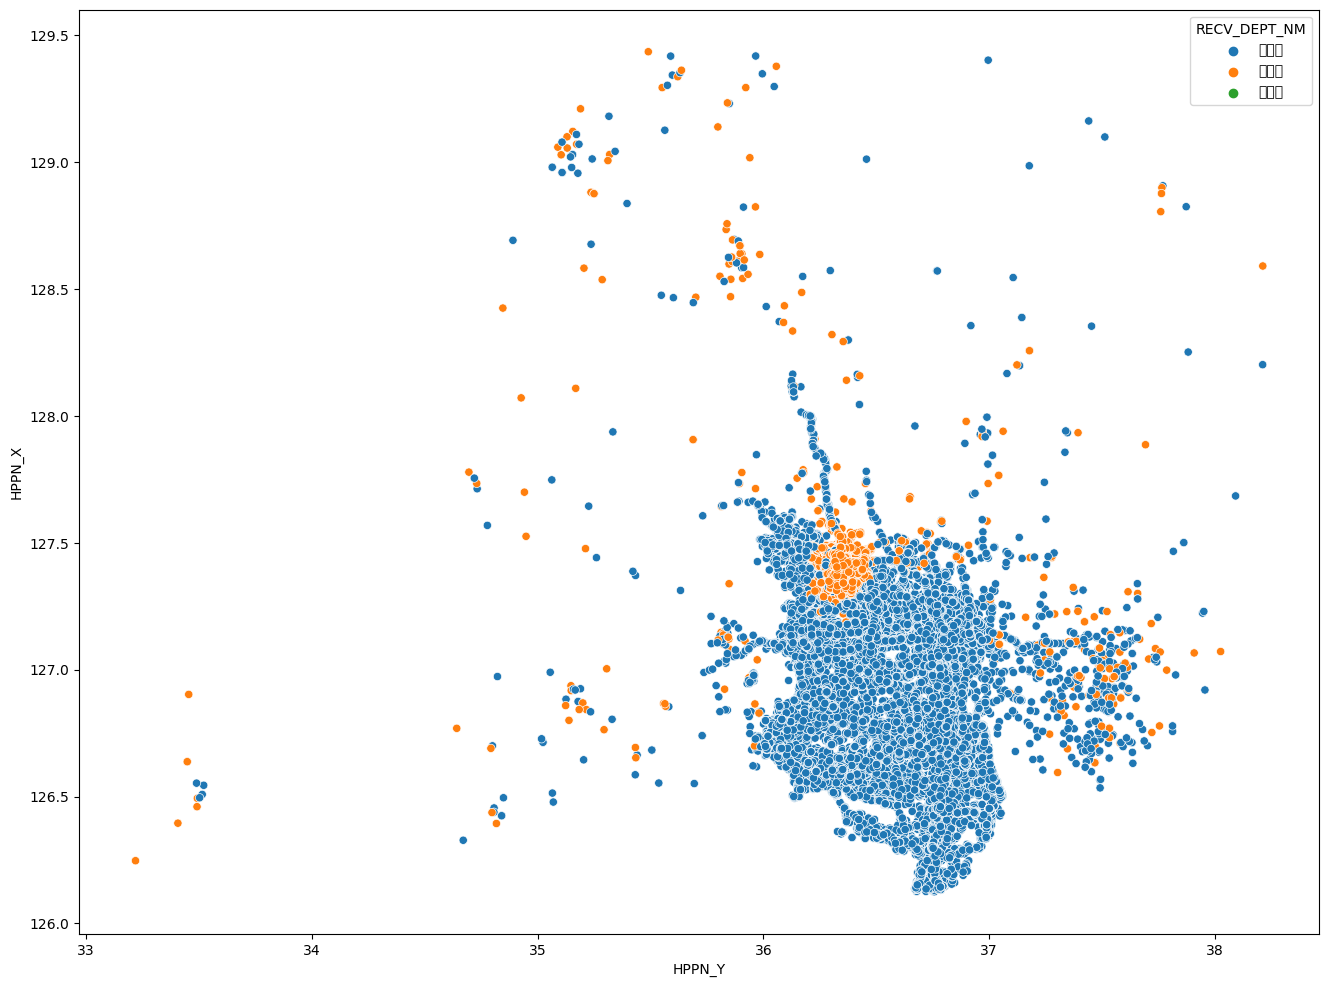

In [53]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="HPPN_Y", y="HPPN_X", hue="RECV_DEPT_NM")
plt.show()

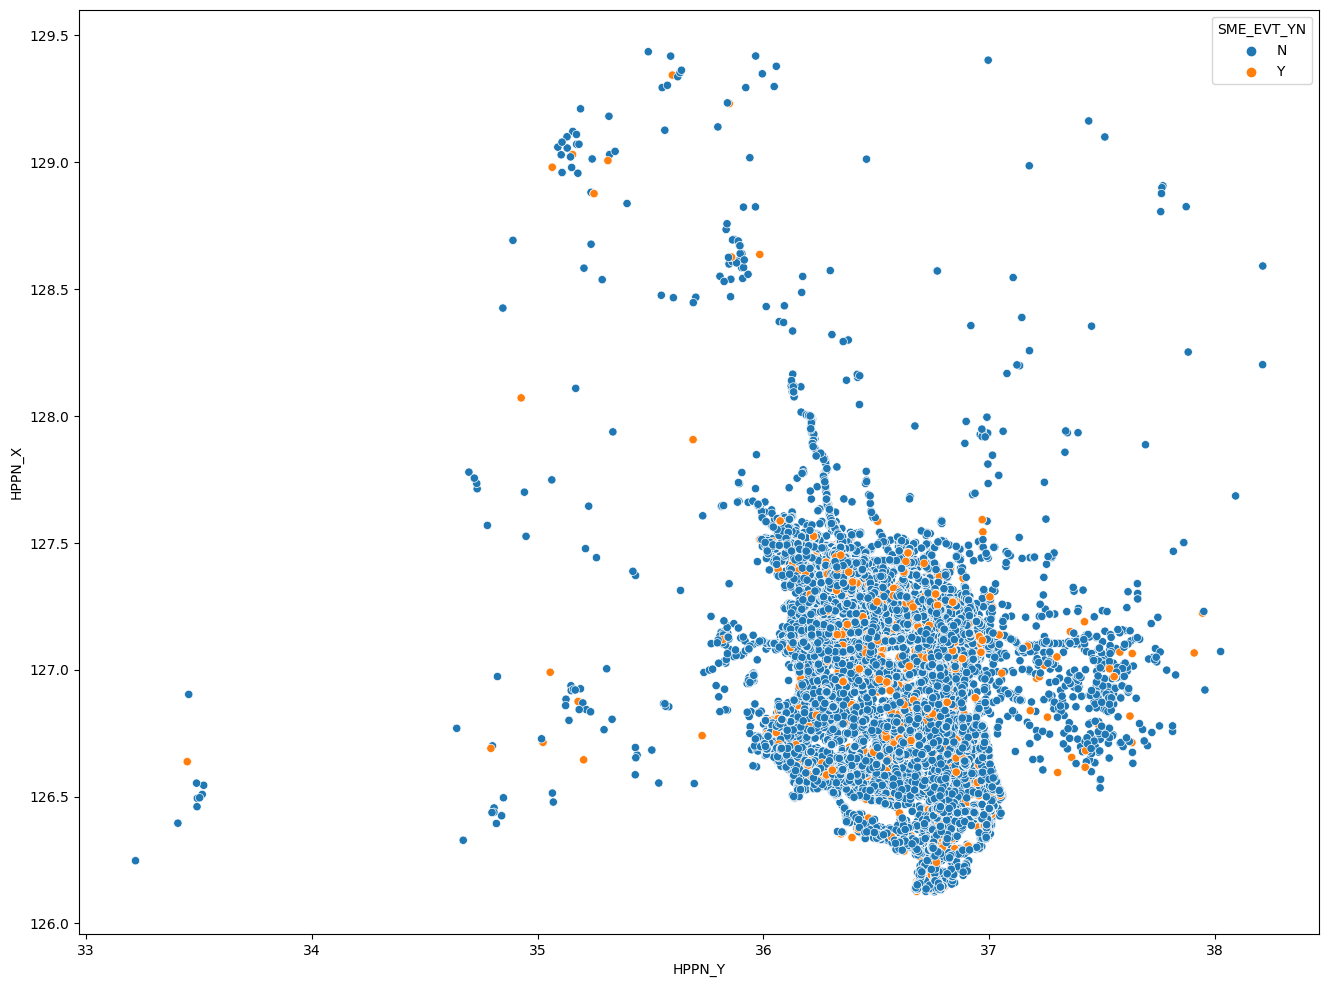

In [54]:
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="HPPN_Y", y="HPPN_X", hue="SME_EVT_YN")
plt.show()

In [50]:
le = LabelEncoder()

le.fit(data['DAY_OF_WEEK'])
data['DAY_OF_WEEK'] = le.transform(data['DAY_OF_WEEK'])
data

,RECV_DEPT_NM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,충남청,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,6
7,대전청,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,6
8,충남청,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,6
9,대전청,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,6
10,대전청,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177991,대전청,13,10,401,1,127.384612,36.377690,Y,2020,11,20,12,57,6,0
1178004,충남청,19,10,402,1,127.014461,36.161151,N,2020,11,20,10,26,22,0
1178016,충남청,19,10,406,1,127.159432,36.800444,N,2020,11,22,0,2,49,4
1178083,대전청,13,10,406,1,127.404540,36.325219,N,2020,11,22,0,20,7,4


In [64]:
feature = data[['HPPN_Y', 'HPPN_X', 'HOUR', 'DAY_OF_WEEK']]
dbscan_model = DBSCAN(min_samples = 2000)
predict = pd.DataFrame(dbscan_model.fit_predict(feature))
predict.columns = ['predict']

predict

,predict
0,6
1,-1
2,-1
3,-1
4,-1
...,...
422559,68
422560,67
422561,40
422562,40


In [66]:
predict.describe()

,predict
count,422564.000000
mean,36.342403
std,33.862470
min,-1.000000
25%,-1.000000
50%,32.000000
75%,64.000000
max,103.000000


In [89]:
#r = pd.concat([feature, predict], axis = 1, ignore_index=True)
feature
x = pd.concat([feature.reset_index(), predict.reset_index()], axis = 1)
x.drop(['index'], axis = 1, inplace = True)
x

,HPPN_Y,HPPN_X,HOUR,DAY_OF_WEEK,predict
0,36.826718,127.137160,8,6,6
1,36.353696,127.341551,3,6,-1
2,36.917900,127.136142,7,6,-1
3,36.306724,127.447545,7,6,-1
4,36.306694,127.447175,7,6,-1
...,...,...,...,...,...
422559,36.377690,127.384612,12,0,68
422560,36.161151,127.014461,10,0,67
422561,36.800444,127.159432,0,4,40
422562,36.325219,127.404540,0,4,40


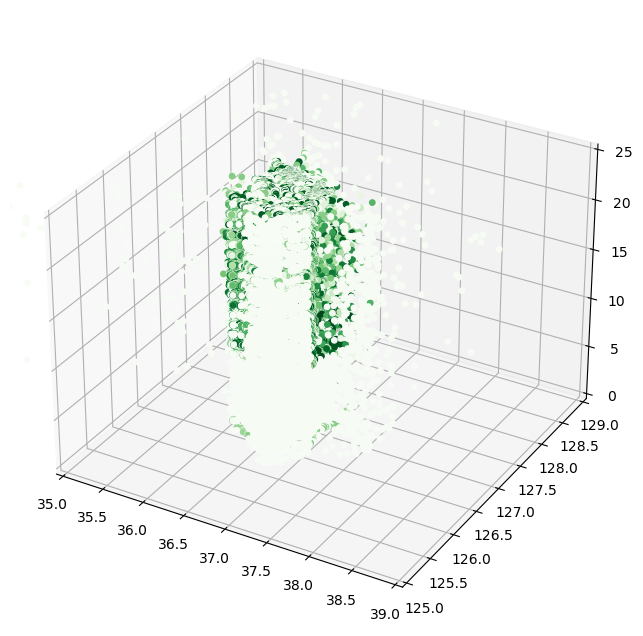

In [98]:
from mpl_toolkits.mplot3d import Axes3D


xs = x['HPPN_Y']
ys = x['HPPN_X']
zs = x['HOUR']
color = x['predict']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(35, 39)
ax.set_ylim(125, 129)
ax.set_zlim(0, 25)
ax.scatter(xs, ys, zs, c=color, marker='o', s=15, cmap='Greens')

plt.show()

In [ ]:
# predict 시간별로 나눠서 다시 clustering 후 value count 한 뒤 신무진 지도찍으라 시키기